# LSTM Implementation and Experiments

This notebook demonstrates the LSTM implementation and experiments. We'll work with the NusaX-Sentiment dataset to perform text classification.

In [78]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from sklearn.metrics import f1_score, classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from src.models.src.models.lstm.nusax_loader import NusaXLoader
from src.models.src.models.lstm.experiments import LSTMExperiments
from src.models.src.models.lstm.lstm_model import LSTMModel
from src.models.src.models.lstm.lstm_layer import LSTMLayer
from src.models.src.models.lstm.embedding_layer import EmbeddingLayer
from src.models.src.models.base_model.layers.dense_layer import DenseLayer
from src.models.src.models.base_model.layers.dropout_layer import DropoutLayer
from src.models.src.models.base_model.layers.activation_layer import Softmax
from src.models.src.models.base_model.utils.evaluation import compare_keras_vs_scratch
from src.models.src.models.base_model.utils.visualization import plot_training_history

In [80]:
# MacOS GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Num GPUs Available: {len(gpus)}")
        print(f"Num Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available: 1
Num Logical GPUs: 1


## 1. Load Data

In [81]:
# Initialize the data loader
data_loader = NusaXLoader(batch_size=32)

# Train
train_dataset = data_loader.get_dataset('train')
for tokens, labels in train_dataset.take(1):
    sample_tokens = tokens.numpy()
    sample_labels = labels.numpy()
    break

# Get vocabulary
vocab = data_loader.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(f"First 20 words in vocabulary: {vocab[:20]}")

# Decode a few examples
print("\nSample texts:")
for i in range(3):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_tokens[i] if idx > 0]
    text = " ".join(words)
    print(f"Text {i+1}: {text}")
    print(f"Label: {sample_labels[i]}\n")

Vocabulary size: 2836
First 20 words in vocabulary: ['', '[UNK]', 'yang', 'di', 'dan', 'tidak', 'saya', 'dengan', 'enak', 'ini', 'makan', 'untuk', 'ke', 'tempat', 'makanan', 'juga', 'sangat', 'ada', 'banyak', 'karena']

Sample texts:
Text 1: nikmati cicilan 0 hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni
Label: 1

Text 2: kuekue yang disajikan bikin saya bernostalgia semuanya tipikal kue zaman dulu baik dari penampilan maupun rasa kuenya enak dan harganya juga murah
Label: 2

Text 3: ibu pernah bekerja di grab indonesia
Label: 1



## 2. Hyperparameter Experiments with LSTM

In [82]:
experiments = LSTMExperiments(data_loader=data_loader,batch_size=32, epochs=10, embedding_dim=100)

Vocabulary size: 2836
Number of classes: 3
Maximum sequence length: 100
Batch size: 32
Epochs: 10
Embedding dimension: 100


### 2.1 Experiment: Number of LSTM Layers


=== Training model with 1 LSTM Layer ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3923 - loss: 1.0895 - val_accuracy: 0.3800 - val_loss: 1.0866
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3450 - loss: 1.0922 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3732 - loss: 1.0806 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3278 - loss: 1.0840 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3532 - loss: 1.0805 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3459 - loss: 1.0852 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3500 - loss: 1.0830 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3494 - loss: 1.0831 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_43 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,707 (4.59 MB)

 Trainable params: 401,235 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 802,472 (3.06 MB)


=== Training model with 2 LSTM Layers ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4023 - loss: 1.0880 - val_accuracy: 0.3800 - val_loss: 1.0849
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3453 - loss: 1.0939 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3777 - loss: 1.0811 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3491 - loss: 1.0854 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3604 - loss: 1.0833 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3675 - loss: 1.0814 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3470 - loss: 1.0810 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3277 - loss: 1.0815 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_44 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,351,355 (5.16 MB)

 Trainable params: 450,451 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 900,904 (3.44 MB)


=== Training model with 3 LSTM Layers ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.4001 - loss: 1.0890 - val_accuracy: 0.3800 - val_loss: 1.0845
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3561 - loss: 1.0918 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3667 - loss: 1.0823 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3461 - loss: 1.0872 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3559 - loss: 1.0811 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3804 - loss: 1.0815 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3942 - loss: 1.0807 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3349 - loss: 1.0861 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_45 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,388,315 (5.30 MB)

 Trainable params: 462,771 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 925,544 (3.53 MB)

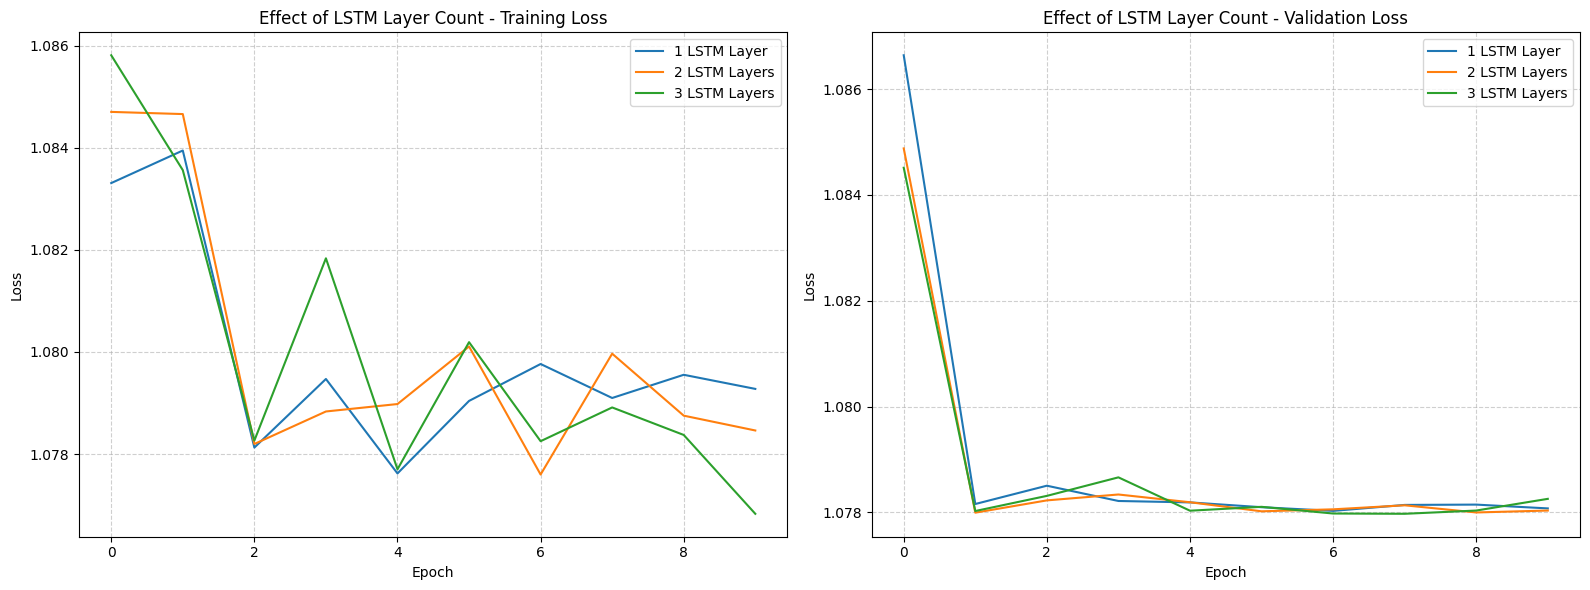

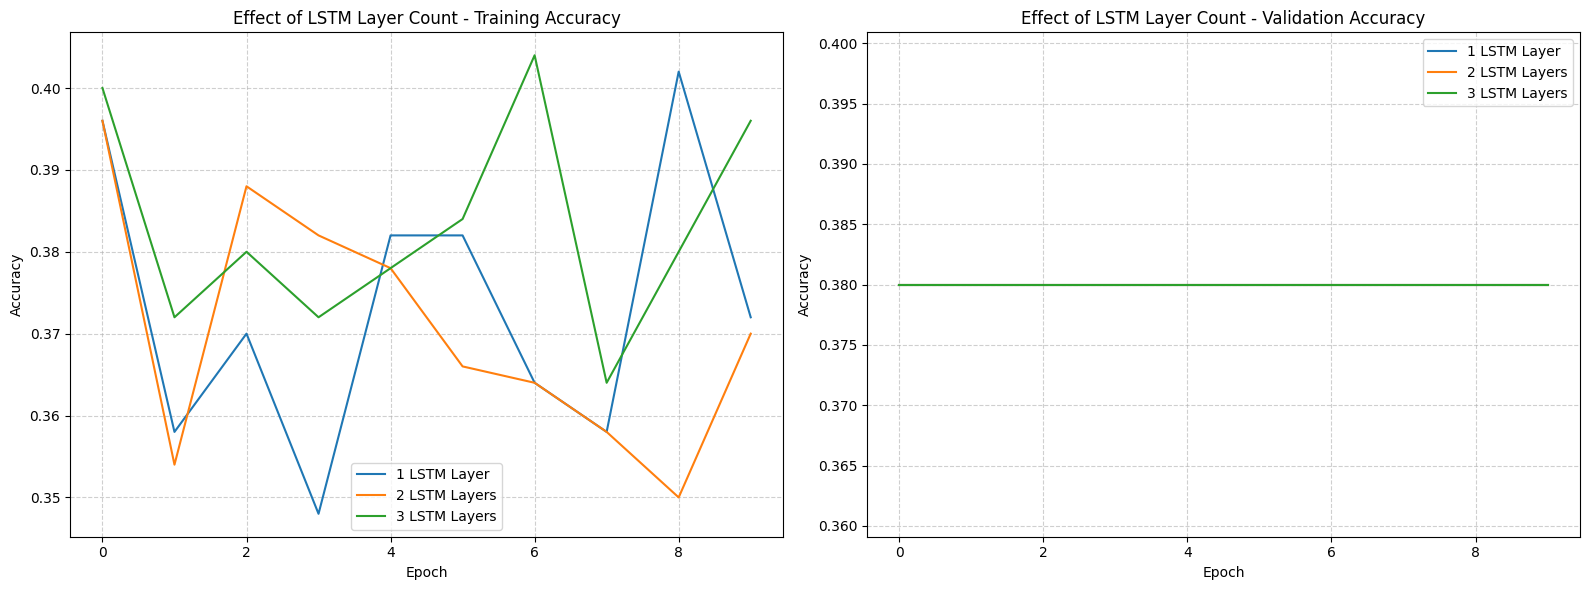

In [83]:
# Define variants for number of LSTM layers
layer_count_variants = [
    (1, "1 LSTM Layer"),
    (2, "2 LSTM Layers"),
    (3, "3 LSTM Layers")
]

# Run experiment
layer_count_models, layer_count_histories = experiments.run_layer_count_experiment(layer_count_variants)

### 2.2 Experiment: Number of LSTM Cells per Layer


=== Training model with 64 Cells ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3814 - loss: 1.0928 - val_accuracy: 0.3800 - val_loss: 1.0801
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3422 - loss: 1.0896 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3259 - loss: 1.0835 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3249 - loss: 1.0821 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3109 - loss: 1.0826 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3747 - loss: 1.0808 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3609 - loss: 1.0803 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3079 - loss: 1.0822 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_46 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 978,107 (3.73 MB)

 Trainable params: 326,035 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 652,072 (2.49 MB)


=== Training model with 128 Cells ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3994 - loss: 1.0886 - val_accuracy: 0.3800 - val_loss: 1.0856
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3462 - loss: 1.0940 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3787 - loss: 1.0804 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3375 - loss: 1.0807 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3534 - loss: 1.0808 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3474 - loss: 1.0807 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3487 - loss: 1.0795 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3593 - loss: 1.0825 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_47 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,707 (4.59 MB)

 Trainable params: 401,235 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 802,472 (3.06 MB)


=== Training model with 256 Cells ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.3975 - loss: 1.0898 - val_accuracy: 0.3800 - val_loss: 1.0893
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3398 - loss: 1.0963 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3723 - loss: 1.0784 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3348 - loss: 1.0850 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3398 - loss: 1.0830 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3588 - loss: 1.0817 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3437 - loss: 1.0849 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3278 - loss: 1.0833 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_48 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_66 (LSTM)                  │ (None, 256)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,949,819 (7.44 MB)

 Trainable params: 649,939 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,299,880 (4.96 MB)

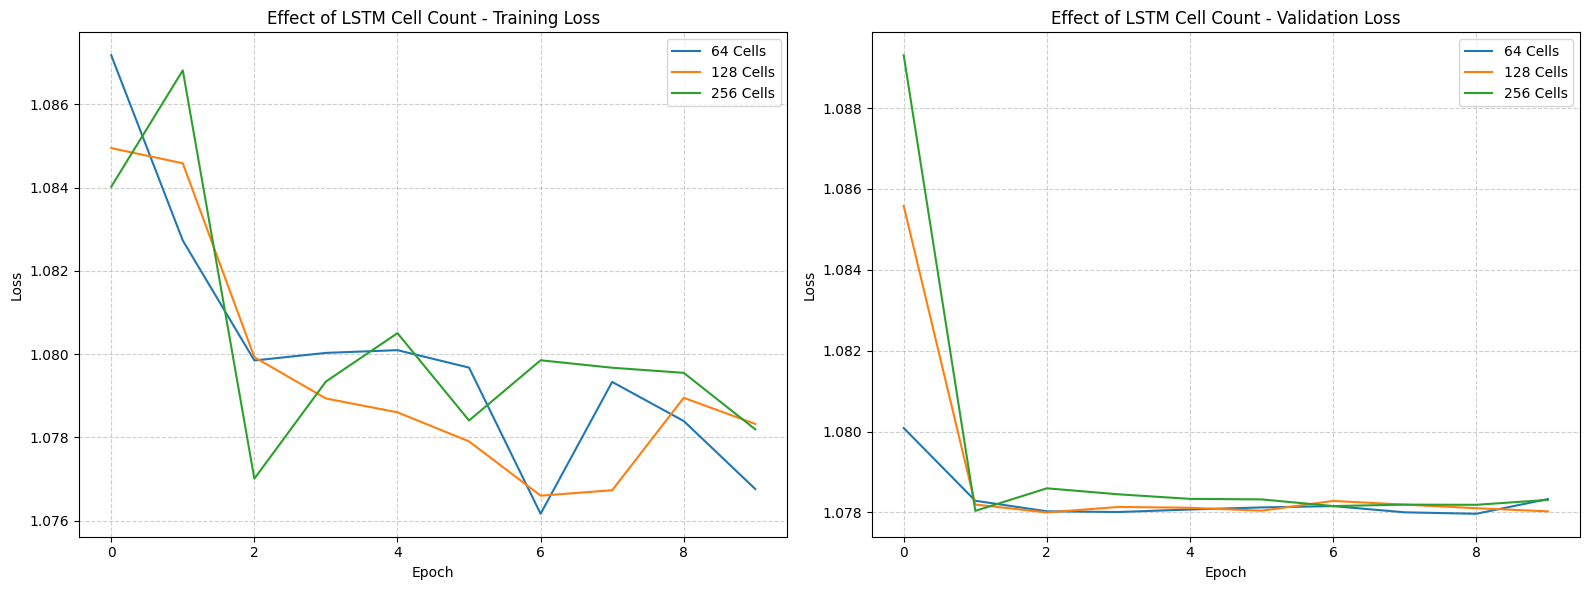

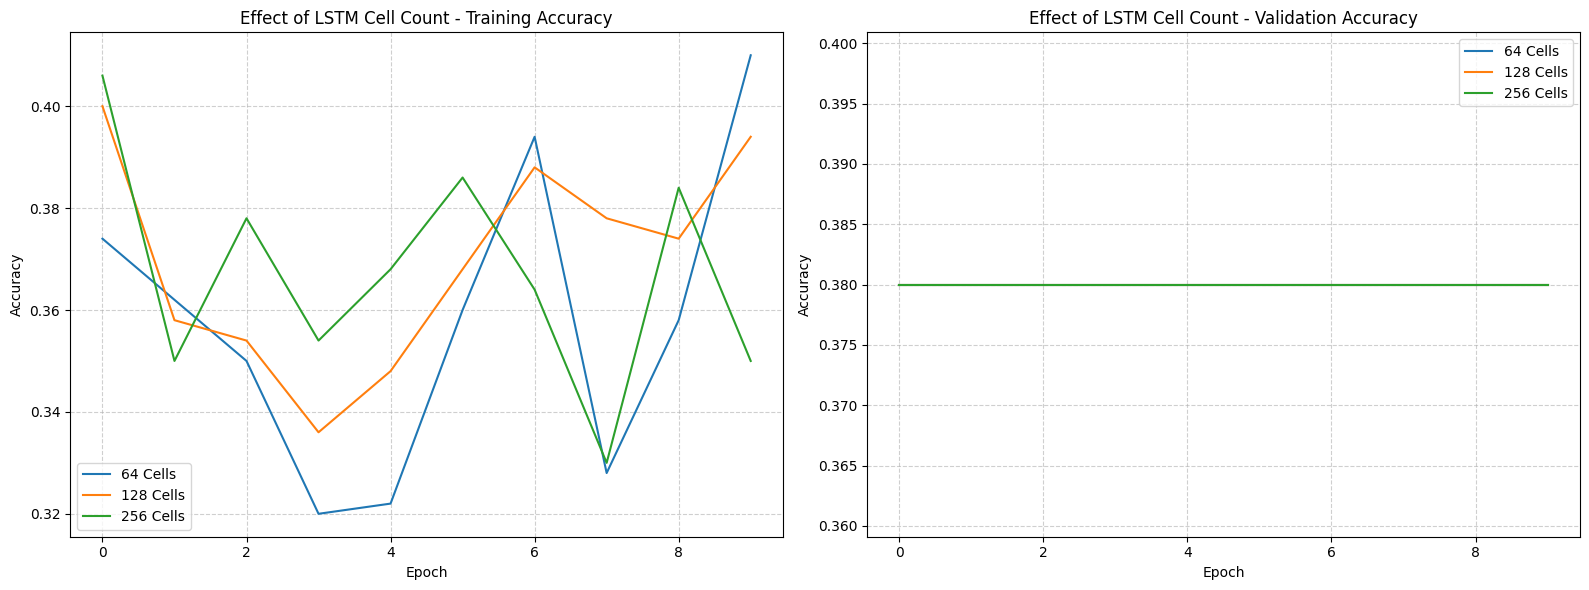

In [84]:
# Define variants for cell counts
cell_count_variants = [
    ([64], "64 Cells"),
    ([128], "128 Cells"),
    ([256], "256 Cells")
]

# Run experiment
cell_count_models, cell_count_histories = experiments.run_cell_count_experiment(cell_count_variants)


### 2.3 Experiment: LSTM Direction


=== Training model with Unidirectional LSTM ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3865 - loss: 1.0895 - val_accuracy: 0.3800 - val_loss: 1.0838
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3318 - loss: 1.0909 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3731 - loss: 1.0807 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3421 - loss: 1.0847 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3654 - loss: 1.0806 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3644 - loss: 1.0842 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3498 - loss: 1.0827 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3232 - loss: 1.0846 - val_accuracy: 0.3800 - val_loss: 1.

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_49 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,707 (4.59 MB)

 Trainable params: 401,235 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 802,472 (3.06 MB)


=== Training model with Bidirectional LSTM ===
Epoch 1/10


/Users/dewo/Documents/informatics/repositories/college/semester-6/ml/Tubes2_ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.4343 - loss: 1.0709 - val_accuracy: 0.5200 - val_loss: 0.9866
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5124 - loss: 0.9290 - val_accuracy: 0.5600 - val_loss: 0.9233
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6738 - loss: 0.7352 - val_accuracy: 0.5900 - val_loss: 0.8445
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7533 - loss: 0.5552 - val_accuracy: 0.6300 - val_loss: 0.8870
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8432 - loss: 0.3933 - val_accuracy: 0.6500 - val_loss: 0.8537
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9601 - loss: 0.1981 - val_accuracy: 0.7300 - val_loss: 0.7847
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9831 - loss: 0.0778 - val_accuracy: 0.6800 - val_loss: 0.9168
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9935 - loss: 0.0525 - val_accuracy: 0.7300 - val_loss: 0.

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_50 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,556,603 (5.94 MB)

 Trainable params: 518,867 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,037,736 (3.96 MB)

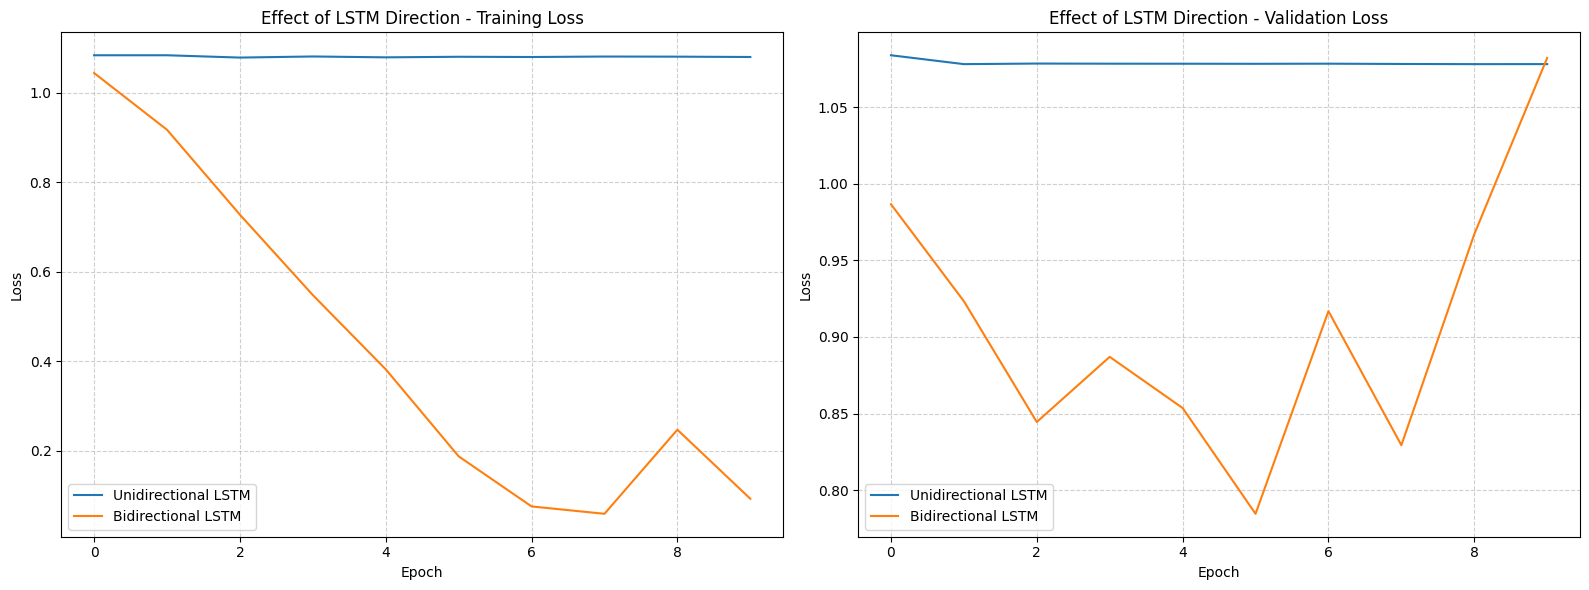

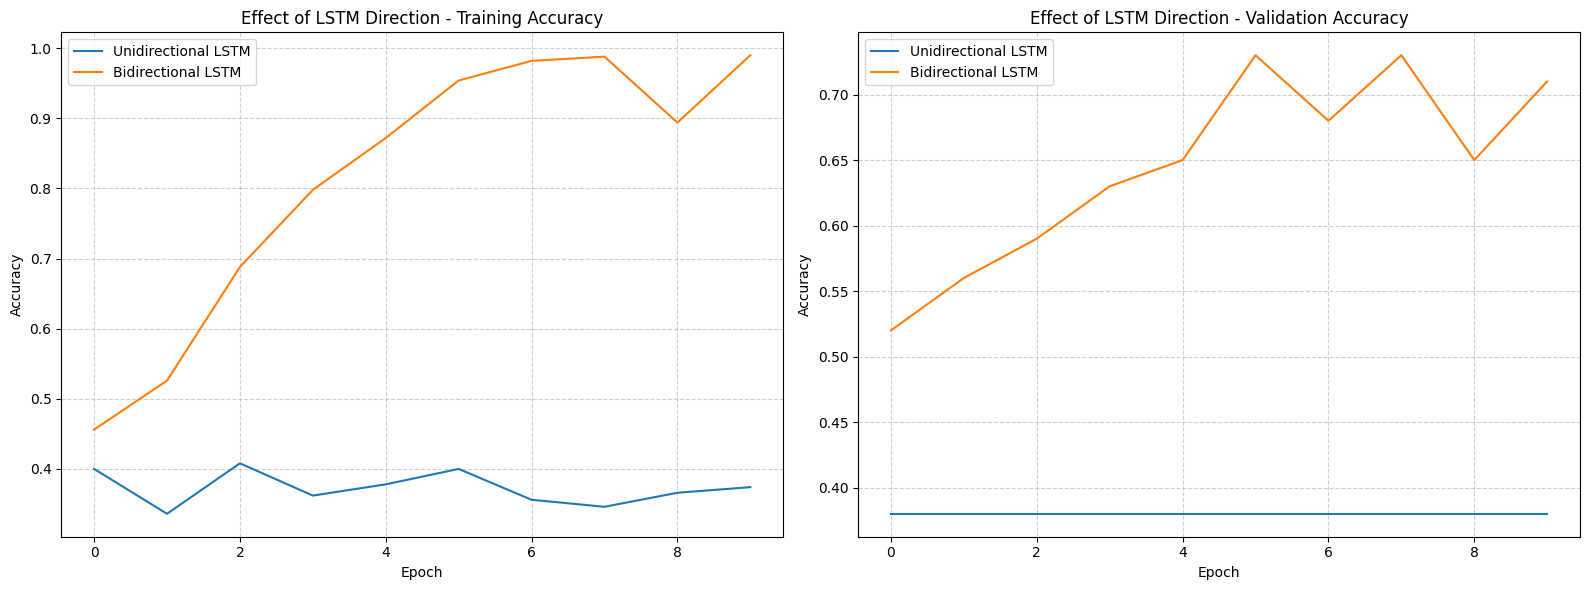

In [85]:
# Define variants for LSTM direction
direction_variants = [
    (False, "Unidirectional LSTM"),
    (True, "Bidirectional LSTM")
]

# Run experiment
direction_models, direction_histories = experiments.run_direction_experiment(direction_variants)


## 3. From-Scratch LSTM Implementation

In [90]:
# Choose one of the trained models (e.g., from the bidirectional experiment)
keras_model = direction_models[1][0]  # Bidirectional LSTM model

# Summary of the chosen model
keras_model.summary()

# Save the model weights
keras_model.save_weights('../output/models/lstm/lstm_model.weights.h5')

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_50 (Embedding)        │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,556,603 (5.94 MB)

 Trainable params: 518,867 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,037,736 (3.96 MB)

In [91]:
# Get embedding dimension and vocabulary size
embedding_dim = 100
vocab_size = len(data_loader.get_vocabulary())
hidden_dim = 128
num_classes = data_loader.num_classes
sequence_length = data_loader.max_sequence_length

# Create a from-scratch LSTM model that matches the Keras model
scratch_model = LSTMModel()

# Add layers corresponding to the Keras model architecture
scratch_model.add(EmbeddingLayer(input_dim=vocab_size, output_dim=embedding_dim))
scratch_model.add(LSTMLayer(input_dim=embedding_dim, hidden_dim=hidden_dim, bidirectional=True))
scratch_model.add(DropoutLayer(dropout_rate=0.2))
scratch_model.add(DenseLayer(input_dim=hidden_dim*2, output_dim=num_classes, activation=Softmax()))

# Load weights from the Keras model
scratch_model.load_weights_from_keras(keras_model)

print("Weights loaded from Keras model to from-scratch implementation.")

Weights loaded from Keras model to from-scratch implementation.


In [94]:
# Get test data
x_test, y_test = data_loader.get_vectorized_data('test')

# Compare predictions
comparison = compare_keras_vs_scratch(keras_model, scratch_model, x_test, y_test, batch_size=32)

print("\nKeras Model Metrics:")
print(f"Accuracy: {comparison['keras_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['keras_metrics']['macro_f1']:.4f}")

print("\nFrom-Scratch Model Metrics:")
print(f"Accuracy: {comparison['scratch_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['scratch_metrics']['macro_f1']:.4f}")

print(f"\nModel Agreement: {comparison['model_agreement']:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Keras Model Metrics:
Accuracy: 0.6975
Macro F1-Score: 0.6714

From-Scratch Model Metrics:
Accuracy: 0.7025
Macro F1-Score: 0.6724

Model Agreement: 0.9850


In [95]:
# Get a few test samples
num_samples = 5
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
sample_texts = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# Make predictions with both models
keras_preds = np.argmax(keras_model.predict(sample_texts), axis=1)
scratch_preds = scratch_model.predict(sample_texts)

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Visualize the results
for i in range(num_samples):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_texts[i] if idx > 0]
    text = " ".join(words)
    
    # Show true label and predictions
    keras_correct = keras_preds[i] == sample_labels[i]
    scratch_correct = scratch_preds[i] == sample_labels[i]
    
    print(f"\nText: {text[:100]}{'...' if len(text) > 100 else ''}")
    print(f"True sentiment: {sentiment_labels[sample_labels[i]]}")
    print(f"Keras prediction: {sentiment_labels[keras_preds[i]]} {'✓' if keras_correct else '✗'}")
    print(f"Scratch prediction: {sentiment_labels[scratch_preds[i]]} {'✓' if scratch_correct else '✗'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Text: dasar tak [UNK] diri kau belajar [UNK] bukan untuk di [UNK] tapi untuk melindungi diri sendiri [UNK]...
True sentiment: Negative
Keras prediction: Negative ✓
Scratch prediction: Negative ✓

Text: hai [UNK] untuk [UNK] tiket [UNK] jadwal diharuskan [UNK] pembayaran dulu ya
True sentiment: Neutral
Keras prediction: Neutral ✓
Scratch prediction: Neutral ✓

Text: restoran dengan [UNK] penyajian berbeda piring tempat makan diganti dengan [UNK] daun pisang menu ma...
True sentiment: Positive
Keras prediction: Positive ✓
Scratch prediction: Positive ✓

Text: kafe ini menyediakan makanan tradisional [UNK] kafe anak muda selain tempat yang nyaman harga terbil...
True sentiment: Positive
Keras prediction: Positive ✓
Scratch prediction: Positive ✓

Text: ini salah satu [UNK] generasi yang tidak berguna bukan malah [UNK] untuk [UNK] tapi malah jadi [UNK]...
True sentiment: Negative
Keras prediction: Negative ✓
Scratch prediction: Negative ✓
